In [220]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pystan

from IPython.display import display

from matplotlib import rc
rc("font", family="serif", size=11)

First we will read in a file that contains the overall list of all the available datasets, with corresponding star IDs, $\nu_{max}$ and $\sigma_{\nu_{max}}$ values. From this we will take a random selection for our analysis.

In [374]:
#random.seed(81)
#random.seed(68)
#output = pd.read_csv('../data/output_1000stars.csv', usecols=range(1,4))
output = pd.read_csv('../data/output_back.csv', usecols=['kic','numax', 'numax_err'])
output = output.loc[(np.abs(output['numax'] - 75) < 30.0)].reset_index(drop=True)
# Select a random number of stars from the file, recording their IDs
IDs = [random.choice(output['kic']) for i in range(5)]
# Create a list of the numax values corresponding to each ID
Numax = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax'] for i in range(len(IDs))]
Numax_err = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax_err'] for i in range(len(IDs))]

Using our list of selected stars, we can then pull the respective files containing the induvidual mode frequencies and errors. The different files will contain varying numbers of modes; in order to successfully parse the data through Stan, one must ensure that all the arrays are of the same length. To do this, for every dataset that contains less modes than the most complete dataset, we can produce additional modes based on the average frequency spacing $\left<\Delta\nu\right>$ for each star, ensuring to assign these points with a large uncertainty so that Stan does not use this as restrictive points during the fit (they are essentially ignored).

In [375]:
modesID = [pd.read_csv('../data/rgbmodes/modes_'+str(IDs[i])+'.csv', usecols=['f0', 'f0_err', 'A0'])
           for i in np.arange(0,len(IDs),1)]
lenmodes = [len(modesID[i]) for i in range(len(IDs))]
maxmodes = max(lenmodes)
arr_n = np.zeros([len(IDs),maxmodes])
arr_freq = np.zeros([len(IDs),maxmodes])
arr_freqerr = np.zeros([len(IDs),maxmodes])


dnu_avgID = []
for i in np.arange(0,len(IDs),1):
    modesID[i] = modesID[i].sort_values(by=['f0'])
    modesID[i] = modesID[i].set_index(np.arange(0,len(modesID[i]),1))
    modesID[i]['dnu'] = (modesID[i]['f0'].diff(2).shift(-1))/2
    dnu_avg = (np.mean(modesID[i]['dnu']))
    dnu_avgID.append(dnu_avg)
    
    n_min = int(modesID[i]['f0'].min() / dnu_avg)
    n = np.arange(n_min, n_min+len(modesID[i]), 1)
    modesID[i].insert(loc=0, column='n', value=n)
    
    # Loop to ensure all arrays are the same length
    if lenmodes[i] < maxmodes:
        l = lenmodes[i]
        while l < maxmodes:
            newrow = {'n': int(np.max(modesID[i]['n'])+1),
                      'f0': np.max(modesID[i]['f0'])+dnu_avgID[i],
                      'f0_err': 10e9}
            modesID[i] = modesID[i].append(newrow, ignore_index=True)
            l += 1
        
    arr_n[i,:] = modesID[i]['n']
    arr_freq[i,:] = modesID[i]['f0']
    arr_freqerr[i,:] = modesID[i]['f0_err']
    
    #display(modesID[i])
    
dnu_avgarr = np.asarray(dnu_avgID)
print(dnu_avgarr)

#Define start parameters
eps = []
for i in range(len(IDs)):
    epsilon1 = np.median((modesID[i].f0 % dnu_avg) / dnu_avg)
    eps.append(epsilon1)
epsilon = np.asarray(eps)

numax_obs = Numax
nmax = numax_obs/dnu_avgarr - epsilon
alpha = 0.015*dnu_avgarr**(-0.32)
A = 0.06*dnu_avgarr**(-0.88) 
G = np.ones([len(IDs)])*3.08
tau = np.ones([len(IDs)])*10
phi = np.ones([len(IDs)])*1.71

[5.87654908 5.7598295  4.81830945 6.09675837 6.04990753 8.7632768
 6.15913732 6.24582832 5.4510537  5.11058559]


The data for the different stars can be viewed on an Échelle Diagram.

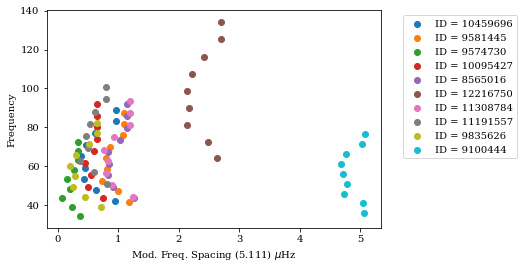

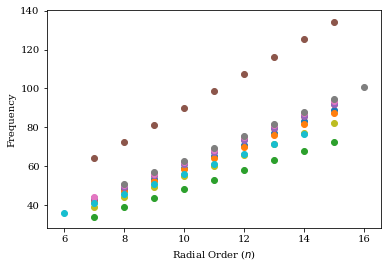

[0.00851083 0.00856565 0.00906912 0.00841123 0.00843202 0.00748924
 0.00838388 0.00834646 0.00871801 0.00889981]


In [376]:
plt.figure(1)
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))

plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(u"%.3f" % dnu_avg) +') $\mu$Hz')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
#plt.savefig('seminar/manyrgbs.pdf')

plt.figure(2)
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['n'], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))
plt.xlabel('Radial Order ($n$)')
plt.ylabel('Frequency')
plt.show()

print(alpha)

With all our required data, we can parse the data into a stan model constructed to perform a hierarchical Bayesian model. Hyperpriors have been introduced on a number of parameters based on values in the Vrard (2014) paper.

In [209]:
code = '''
functions {
    real noglitch(real n, real dnu, real numax, real epsilon, real alpha){
        return (n + epsilon + alpha/2 * (n-(numax/dnu - epsilon))^2) * dnu;
    }
}

data {
    int N; //number of stars
    int M; //number of modes
    real n[N, M];
    real freq[N, M];
    real freq_err[N, M];
    real numax_obs[N];
    real numax_err[N];
    real dnu_guess[N];
}

parameters {
    real dnu[N];
    real<lower=0> numax[N];
    real epsilon_std[N];
    real<lower=0> eps_std;
    real epsA;
    real epsB;
    real alpha_std[N];
    real<lower=0> al_std;
    real alA;
    real alB;
}

transformed parameters {
    real epsilon[N];
    real alpha[N];
    for (i in 1:N){
        epsilon[i] = epsilon_std[i] * eps_std + (epsA + epsB * log(dnu[i]));
        alpha[i] = alpha_std[i] * al_std + (alA * (dnu[i])^(-alB));
    }
}


model {
    real mod[M];
    for (i in 1:N){
        for (j in 1:M){
            mod[j] = noglitch(n[i,j], dnu[i], numax[i], epsilon[i], alpha[i]);
            //mod[j] ~ normal(freq[i], freq_err[i]);
        }
        freq[i,:] ~ normal(mod, freq_err[i,:]);
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.001);
    }
    
    numax ~ normal(numax_obs, numax_err);
    
    epsilon_std ~ normal(0, 1);
    eps_std ~ normal(0, 0.5);
    epsA ~ normal(0.601, 0.25);
    epsB ~ normal(0.632, 0.25);
    alpha_std ~ normal(0, 1);
    al_std ~ normal(0, 0.5);    
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08); 
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_90bdd4dd0d7f292da4f048e131536b1f NOW.


In [377]:
stan_data = {'N': len(IDs),
         'M': maxmodes,
         'n': arr_n, 
         'freq': arr_freq,
         'freq_err': arr_freqerr,
         'numax_obs': Numax,
         'numax_err': Numax_err,
         'dnu_guess': dnu_avgarr
        }
start = {'dnu': dnu_avgarr,
         'numax': Numax,
         'eps_std': 0.01,
         'al_std': 0.01,
         #'epsilon': epsilon,
         #'alpha': alpha,
         'epsA': 0.601,
         'epsB': 0.632,
         'alA': 0.015,
         'alB': 0.32,
    }
nchains = 4

fit = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)])

In [378]:
print(fit)

Inference for Stan model: anon_model_90bdd4dd0d7f292da4f048e131536b1f.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu[1]            5.87  1.6e-4 4.2e-3   5.86   5.87   5.87   5.88   5.88    713    1.0
dnu[2]            5.77  1.4e-4 3.8e-3   5.76   5.76   5.77   5.77   5.77    775    1.0
dnu[3]            4.82  2.0e-4 4.4e-3   4.81   4.82   4.82   4.83   4.83    489   1.01
dnu[4]            6.09  1.8e-4 4.2e-3   6.08   6.09   6.09   6.09    6.1    586    1.0
dnu[5]            6.06  1.7e-4 4.3e-3   6.05   6.06   6.06   6.06   6.07    629   1.01
dnu[6]            8.78  1.6e-4 4.4e-3   8.77   8.78   8.78   8.78   8.79    766   1.01
dnu[7]            6.16  1.8e-4 4.6e-3   6.15   6.15   6.16   6.16   6.16    641    1.0
dnu[8]            6.25  1.7e-4 4.8e-3   6.24   6.25   6.25   6.25   6.26    771   1.02
dnu[9]            5.45  1.9

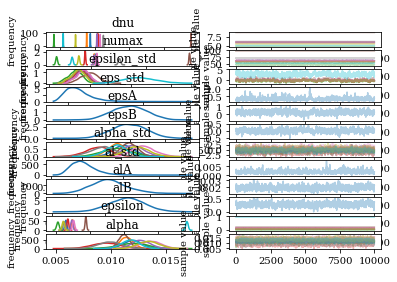

In [379]:
fit.plot()
plt.show()

In [380]:
'''import corner
data = np.vstack([fit['epsilon'], fit['k'], fit['dnu'], fit['nmax'],
                  fit['a'], fit['omega'], fit['phi'], fit['tau']]).T
corner.corner(data, labels=[r'$\epsilon$', r'$k$',r'$\Delta\nu$',r'$n_{max}$',
                            r'$A$', r'$\omega$', r'$\phi$', r'$\tau$'])
              #, truths=[1.436, 0.07, 0.3, 2, 0])
plt.show()'''

"import corner\ndata = np.vstack([fit['epsilon'], fit['k'], fit['dnu'], fit['nmax'],\n                  fit['a'], fit['omega'], fit['phi'], fit['tau']]).T\ncorner.corner(data, labels=[r'$\\epsilon$', r'$k$',r'$\\Delta\nu$',r'$n_{max}$',\n                            r'$A$', r'$\\omega$', r'$\\phi$', r'$\tau$'])\n              #, truths=[1.436, 0.07, 0.3, 2, 0])\nplt.show()"

Real dnu value: [5.8765490790336266, 5.75982949564261, 4.818309447463535, 6.096758373718079, 6.049907530945461, 8.763276798809772, 6.159137316808987, 6.245828319625777, 5.451053700154252, 5.110585588683574]
Stan dnu value: [5.87284539 5.76693938 4.82235056 6.09067466 6.06011005 8.77922889
 6.15523992 6.24936552 5.44604961 5.09111196]
Stan numax value: [61.71730653 61.23752357 47.65375924 57.95960167 61.21386415 95.57205381
 62.16162212 70.30470827 55.69560173 53.25741986]
Stan ε value: [0.07493289 0.12304546 0.01640981 0.08953134 0.11898214 0.22190002
 0.13207776 0.06369437 0.05631665 0.96509643]
Stan α value: [0.01198174 0.0113865  0.01197388 0.00950974 0.01271873 0.01116645
 0.01363209 0.00985705 0.01341537 0.01174613]


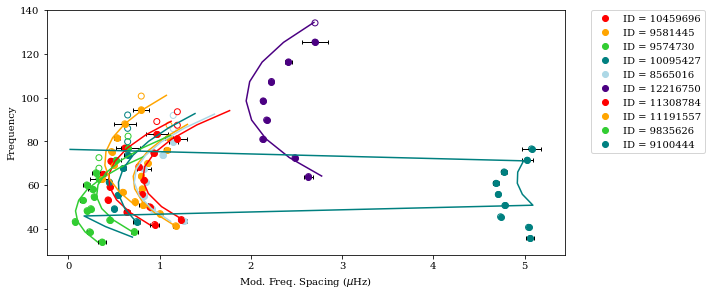

In [381]:
%matplotlib inline
def model(n,dnu,numax,eps,alpha):
    s = (n + eps + ((alpha/2)*(n-(numax/dnu + eps))**2))*dnu
    return s


fig = plt.figure(1, figsize=(12,4))
ax  = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.6,0.85])

import itertools as itr
colours = itertools.cycle(('r', 'orange', 'limegreen', 'teal', 'lightblue', 'indigo'))

for i in np.arange(0,len(IDs),1):
    # Iterate point colour
    colour = next(colours)
    # Plot all frequencies, and errorbars for the 'true' data
    ax.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label='', zorder=-1, facecolors='none', edgecolors=colour)
    pts = modesID[i].loc[(modesID[i]['f0_err'] < 10e3)]
    ax.scatter(pts['f0'] % dnu_avgID[i], pts['f0'],
                label=r'ID = '+str(IDs[i]), c=colour)
    ax.errorbar(pts['f0'] % dnu_avgID[i], pts['f0'], xerr=pts['f0_err'],
                        zorder=0, fmt="none", label='', c='k',
                        capsize=2, markersize=4, elinewidth=1)   
    
    # Plot the modelled fit
    g2 = model(arr_n[i],
           np.mean(fit['dnu'], axis=0)[i],
           np.mean(fit['numax'], axis=0)[i],
           np.mean(fit['epsilon'], axis=0)[i],
           np.mean(fit['alpha'], axis=0)[i])
    
    ax.plot(g2 % np.mean(fit['dnu'], axis=0)[i], g2,
             c=colour)
    

#print(arr_n[0])
print('Real dnu value:', dnu_avgID)
print('Stan dnu value:', np.mean(fit['dnu'], axis=0))
print('Stan numax value:', np.mean(fit['numax'], axis=0))
print('Stan ε value:', np.mean(fit['epsilon'], axis=0))
print('Stan α value:', np.mean(fit['alpha'], axis=0))


plt.legend()
plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ($\mu$Hz)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('seminar/somergbseizure.pdf', bbox='tight_layout')

In [382]:
#fitdf = fit.to_dataframe(permuted=True)
#display(fitdf)

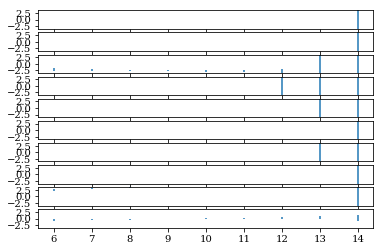

In [383]:
fig, ax = plt.subplots(len(IDs))
for i in np.arange(0,len(IDs),1):
    ax[i].errorbar(modesID[i]['n'], modesID[i]['f0'] - g2, yerr=modesID[i]['f0_err']*10, linestyle='none')
    #ax[i].set_xlim([6,20])
    ax[i].set_ylim([-3.5, 3.5])